In [1]:
from SAC.Normal_Policy import Normal_Policy
from SAC.Value_function import Value_function
from SAC.SoftActorCritc import SoftActorCritic, plot

import time
import gym
import numpy as np

import sys
sys.path.insert(0, './../../laser-hockey-env')
import laser_hockey_env as lh
from importlib import reload


In [2]:
env = lh.LaserHockeyEnv(mode=lh.LaserHockeyEnv.TRAIN_DEFENSE)

In [3]:
ac_space = env.action_space
o_space = env.observation_space
print(ac_space.low)
print(o_space)

[-1. -1. -1. -1. -1. -1.]
Box(16,)


In [4]:
direct = "C:/Users/Maximilian/Documents/Studium/Informatik/3. Semester/Intelligent Systems/project/DeepRLHockey/code/SAC/weights/"
save_path_new = direct+"v4"

In [5]:
q_fct_config = {"hidden_layers": [256, 256]}
v_fct_config = {"hidden_layers": [256, 256]}
pi_fct_config = {"hidden_layers": [256, 256], "dim":3}

SAC_agent = SoftActorCritic(o_space=o_space, 
                            a_space=ac_space, 
                            value_fct=Value_function, 
                            policy_fct=Normal_Policy, 
                            env= env,
                            discount=  0.93, 
                            tau = 0.01, 
                            batch_size=256, 
                            alpha = 1.0,
                            lambda_V = 3e-4, 
                            lambda_Pi = 3e-4, 
                            lambda_Q = 3e-4,
                            dim_act = 3,
                            dim_obs = 20,
                            q_fct_config=q_fct_config,
                            v_fct_config=v_fct_config,
                            pi_fct_config=pi_fct_config, 
                            save_path = save_path_new) 

In [6]:
import progressbar

def train(iter_fit=1000, max_steps= 500, env_steps = 1, grad_steps = 1, burn_in =1000):
        bar = progressbar.ProgressBar(max_value=iter_fit)
        # Initilalize target V network
        SAC_agent._sess.run(SAC_agent._update_target_V_ops_hard)
        # Init Statistics      
        total_rewards_per_episode = [] 
        total_loss_V = []
        total_loss_Q1 = []
        total_loss_Q2 = []
        total_loss_PI = []
        winner = []
        moving_avg_winner =np.zeros(20)
        
        
        j = 0
        for i in range(iter_fit):
            
            ob = env.reset()
            distance_to_opponent = np.sqrt((ob[6] -ob[0])**2 + (ob[7] -ob[1])**2)
            distance_to_puck = np.sqrt((ob[12] -ob[0])**2 + (ob[13] -ob[1])**2)
            angle_to_opponent = np.arctan2((ob[7] -ob[1]),(ob[6] -ob[0])) - ob[2]
            angle_to_puck = np.arctan2((ob[13] -ob[1]),(ob[12] -ob[0])) - ob[2]
            ob = np.append(ob, [distance_to_opponent, distance_to_puck,angle_to_opponent, angle_to_puck] )
                    
                    
                    
            total_reward = 0
            
            #puck_hit = 0.0
            #puck_hit_once = False
            for _ in range(max_steps):
                for e_i in range(env_steps):#
                    
                    #env.render()
                    if j < burn_in:
                        a = env.action_space.sample()
                        a = a[:3]
                        #a = self.reverse_action(a)    
                                        
                    else:
                        a = SAC_agent.action(np.asarray(ob).reshape(1, SAC_agent._config["dim_obs"]))
                        a = a[0]
                    a2 = [np.random.uniform(-0.5,0.5,1)[0],np.random.uniform(-0.5,0.5,1)[0],np.random.uniform(-0.1,0.1,1)[0]]  
                    comb_a = np.hstack([a,a2])
                    
                    
                    
                    (ob_new, reward, done, _info) = env.step(comb_a)
                    #reward += _info['winner']*1+  + _info['reward_closeness_to_puck']*1.  + _info['reward_touch_puck']*1  + _info['reward_puck_direction']*1
                    #puck_hit_once = puck_hit_once or _info['reward_touch_puck']
                    #puck_hit *= 0.95
                    #puck_hit = max(puck_hit , _info['reward_touch_puck'])
                    
                    
                    #reward =  abs(min(_info['winner'], puck_hit_once)) *reward  + (1- puck_hit)*_info['reward_closeness_to_puck']  #+ _info['reward_puck_direction']
                    
                    #reward += _info['reward_touch_puck']
                    reward -= 1/250
                    
                    
                    distance_to_opponent = np.sqrt((ob_new[6] -ob_new[0])**2 + (ob_new[7] -ob_new[1])**2)
                    distance_to_puck = np.sqrt((ob_new[12] -ob_new[0])**2 + (ob_new[13] -ob_new[1])**2)
                    angle_to_opponent = np.arctan2((ob_new[7] -ob_new[1]),(ob_new[6] -ob_new[0])) - ob_new[2]
                    angle_to_puck = np.arctan2((ob_new[13] -ob_new[1]),(ob_new[12] -ob_new[0])) - ob_new[2]
                    ob_new = np.append(ob_new, [distance_to_opponent, distance_to_puck,angle_to_opponent, angle_to_puck] )
            
                    
                    total_reward += reward
                    
                    SAC_agent.store_transition(ob, a, reward, ob_new, done)
                    ob=ob_new
  
                if j  >= SAC_agent._config["batch_size"]:
                    for g_i in range(grad_steps):
                        update_value_target = False
                        if i % SAC_agent._config["target_update"] == 0:
                            update_value_target = True
                        loss_V_fct, loss_Q1_fct,loss_Q2_fct,loss_PI_fct= SAC_agent._train(update_value_target)
                        #total_loss_V.append(loss_V_fct)
                        #total_loss_Q1.append(loss_Q1_fct)
                        #total_loss_Q2.append(loss_Q2_fct)
                        #total_loss_PI.append(loss_PI_fct)  
                        
                j += 1
                if done:
                    break 
            moving_avg_winner[i%20]=((_info['winner']+1)/2.0)/20
            winner.append(sum(moving_avg_winner))
            total_rewards_per_episode.append(total_reward)
            if i % 1 == 0:
                plot(total_rewards_per_episode,winning=winner, plot_type = 3) 
            bar.update(i)   
        return total_rewards_per_episode

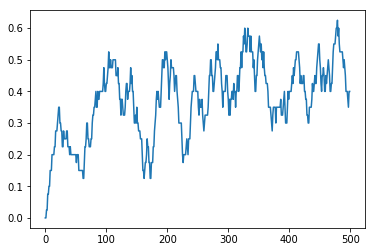

 99% (499 of 500) |##################### | Elapsed Time: 0:52:58 ETA:   0:00:05

[-11.520000000000001,
 -10.171999999999999,
 -2.0000000000000013,
 -10.176,
 9.864,
 -10.164,
 -2.0000000000000013,
 -10.74,
 9.532,
 -10.168,
 -10.171999999999999,
 9.128,
 -10.164,
 -10.18,
 -10.171999999999999,
 -2.0000000000000013,
 -10.176,
 9.42,
 -10.168,
 -10.376,
 -2.0000000000000013,
 -2.0000000000000013,
 9.540000000000001,
 -10.168,
 -10.168,
 -10.168,
 -10.168,
 -10.168,
 -10.171999999999999,
 -10.187999999999999,
 9.620000000000001,
 -2.0000000000000013,
 -10.171999999999999,
 -10.176,
 -10.18,
 9.532,
 -10.164,
 -10.176,
 -10.168,
 -10.176,
 -10.684,
 9.684000000000001,
 -2.0000000000000013,
 -10.168,
 -10.18,
 -11.32,
 -10.184,
 -10.168,
 -10.176,
 -10.18,
 9.544,
 -11.776000000000002,
 -2.0000000000000013,
 -10.392,
 -11.516,
 -10.171999999999999,
 -10.171999999999999,
 -10.176,
 -10.18,
 -10.18,
 -10.176,
 9.404,
 -10.168,
 -10.168,
 9.176,
 9.620000000000001,
 -11.644,
 -2.0000000000000013,
 9.64,
 -10.18,
 -10.164,
 -10.18,
 -10.18,
 -10.18,
 -10.18,
 -2.00000000000

In [7]:
train(500)

In [8]:

for i in range(10):
    ob = env.reset()
    for _ in range(1000):
        env.render()
        distance_to_opponent = np.sqrt((ob[6] -ob[0])**2 + (ob[7] -ob[1])**2)
        distance_to_puck = np.sqrt((ob[12] -ob[0])**2 + (ob[13] -ob[1])**2)
        angle_to_opponent = np.arctan2((ob[7] -ob[1]),(ob[6] -ob[0])) - ob[2]
        angle_to_puck = np.arctan2((ob[13] -ob[1]),(ob[12] -ob[0])) - ob[2]
        ob = np.append(ob, [distance_to_opponent, distance_to_puck,angle_to_opponent, angle_to_puck] )
            
        a = SAC_agent.act_greedy(np.asarray(ob).reshape(1, SAC_agent._config["dim_obs"]))
        a1 = a[0]
        a2 = [np.random.uniform(-0.5,0.5,1)[0],np.random.uniform(-0.5,0.5,1)[0],np.random.uniform(-0.1,0.1,1)[0]]  
                    
        ob, r, d, info = env.step(np.hstack([a1,a2]))    
        obs_agent2 = env.obs_agent_two()
        if d: break
env.close()

Player 1 scored
Player 1 scored
Player 2 scored
Player 1 scored
Player 1 scored
Player 2 scored
Player 2 scored
Player 1 scored
Player 2 scored


In [9]:
saver = SAC_agent._saver
saver.save(SAC_agent._sess, save_path_new)

'C:/Users/Maximilian/Documents/Studium/Informatik/3. Semester/Intelligent Systems/project/DeepRLHockey/code/SAC/weights/v4'